In [1]:
import numpy as np
import pandas as pd

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='paper', style='whitegrid', rc={'figure.figsize':(8, 5), 'figure.dpi': 120})
color_palette = sns.color_palette("Set2")
sns.set_palette(color_palette)

import missingno as msno

## 
### load data

In [2]:
obs = pd.read_csv("./data/climate-data/obs_hist.csv")
mod = pd.read_csv("./data/climate-data/model_hist.csv")
mod_future = pd.read_csv("./data/climate-data/model_RCP85.csv")

## 
### preprocess

#### เพิ่ม column ฤดู

##### ฤดูกาลในไทย
- ฤดูร้อน ประมาณกลางเดือนกุมภาพันธ์ถึงกลางเดือนพฤษภาคม
- ฤดูฝน ประมาณกลางเดือนพฤษภาคมถึงกลางเดือนตุลาคม
- ฤดูหนาว ประมาณกลางเดือนตุลาคมถึงกลางเดือนกุมภาพันธ์

[ref กรมอุตุนิยมวิทยา](https://www.tmd.go.th/info/info.php?FileID=53)

In [3]:
season_range = {
    'summer': ["02-16", "05-15"],
    'rainy': ["05-16", "10-15"],
    'winter': ["10-16", "02-15"]
}

season_encode = {
    'summer': 1,
    'rainy': 2,
    'winter': 3
}

In [4]:
def date_season(date, season_range):
    for season, r in season_range.items():
        start_m, start_d = r[0].split('-')
        start_m, start_d = int(start_m), int(start_d)
        end_m, end_d = r[1].split('-')
        end_m, end_d = int(end_m), int(end_d)

        y = date.year
        m = date.month
        d = date.day

        if start_m < end_m:
            season_month = list(range(start_m, end_m+1))
        else:
            season_month = list(range(start_m, 13)) + list(range(1, end_m+1))

        if m in season_month:
            if (m == season_month[0] and d >= start_d) or (m == season_month[-1] and d <= end_d):
                s = season
            elif m in season_month[1:-1]:
                s = season
    return s

In [5]:
date = dt.datetime.strptime("2020-12-12", "%Y-%m-%d")
date_season(date, season_range)

'winter'

### 
#### add season column

In [6]:
obs_season = []
for date in obs['DATE']:
    date_obj = dt.datetime.strptime(date, "%Y-%m-%d")
    obs_season.append(date_season(date_obj, season_range))
    
obs['season'] = obs_season
obs['season'].replace(season_encode, inplace=True)
obs.head()

,DATE,TAVG,TMIN,TMAX,PRCP,season
0,1943-01-01,23.8,15.0,31.7,NaN,3
1,1943-01-02,23.1,15.0,30.6,NaN,3
2,1943-01-03,22.4,14.4,31.1,NaN,3
3,1943-01-04,22.5,13.9,29.4,NaN,3
4,1943-01-05,21.8,13.9,28.9,NaN,3


In [7]:
mod_season = []
for date in mod['DATE']:
    date_obj = dt.datetime.strptime(date, "%Y-%m-%d")
    mod_season.append(date_season(date_obj, season_range))
    
mod['season'] = mod_season
mod['season'].replace(season_encode, inplace=True)
mod.head()

,DATE,tas,tasmin,tasmax,pr,season
0,1970-01-01,19.0482,11.3441,27.4118,0.306720,3
1,1970-01-02,20.2657,13.3224,29.5520,0.211680,3
2,1970-01-03,20.1890,12.9988,30.2747,0.241056,3
3,1970-01-04,19.2846,12.1844,27.4798,0.454464,3
4,1970-01-05,18.6566,11.4102,28.9179,0.120960,3


In [8]:
mod_future_season = []
for date in mod_future['DATE']:
    date_obj = dt.datetime.strptime(date, "%Y-%m-%d")
    mod_future_season.append(date_season(date_obj, season_range))
    
mod_future['season'] = mod_future_season
mod_future['season'].replace(season_encode, inplace=True)
mod_future.head()

,DATE,tas,tasmin,tasmax,pr,season
0,2006-01-01,20.8318,16.4568,28.3130,0.241920,3
1,2006-01-02,21.1316,16.7057,26.8860,3.058560,3
2,2006-01-03,18.6179,16.3839,20.6999,7.690464,3
3,2006-01-04,17.2149,13.7271,21.8989,0.741312,3
4,2006-01-05,16.8424,12.4152,23.8108,1.029024,3


### 
### join history data

In [9]:
obs = obs.set_index('DATE')
mod = mod.set_index('DATE')
mod_future = mod_future.set_index('DATE')

obs.index = pd.to_datetime(obs.index)
mod.index = pd.to_datetime(mod.index)
mod_future.index = pd.to_datetime(mod_future.index)

In [10]:
hist = obs.join(mod, how='inner', lsuffix='_obs', rsuffix='_mod')
hist['season'] = hist['season_mod']
hist.drop(columns=['season_mod', 'season_obs'], axis=1, inplace=True)

In [11]:
hist.head()

,TAVG,TMIN,TMAX,PRCP,tas,tasmin,tasmax,pr,season
DATE,,,,,,,,,
1970-01-01,NaN,12.6,29.8,0.0,19.0482,11.3441,27.4118,0.306720,3
1970-01-02,NaN,13.5,29.9,0.0,20.2657,13.3224,29.5520,0.211680,3
1970-01-03,NaN,11.9,29.2,0.0,20.1890,12.9988,30.2747,0.241056,3
1970-01-04,NaN,11.8,29.4,0.0,19.2846,12.1844,27.4798,0.454464,3
1970-01-05,NaN,14.4,29.8,0.0,18.6566,11.4102,28.9179,0.120960,3


## 
## EDA

In [12]:
climate_vars = ['TAVG', 'TMIN', 'TMAX', 'PRCP']
obs_to_mod_vars = {
    'TAVG': 'tas',
    'TMAX': 'tasmax',
    'TMIN': 'tasmin',
    'PRCP': 'pr'
}

mod_to_obs_vars = {
    'tas': 'TAVG',
    'tasmax': 'TMAX',
    'tasmin': 'TMIN',
    'pr': 'PRCP'
}


df1 = hist[['TAVG', 'TMIN', 'TMAX', 'PRCP', 'season']]
df1['source'] = 'obs'
df2 = hist[['tas', 'tasmin', 'tasmax', 'pr', 'season']]
df2 = df2.rename(columns=mod_to_obs_vars)
df2['source'] = 'model'

df = pd.concat([df1, df2])
df = df.sort_index()

<ipython-input-12-50b71b927d12>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['source'] = 'obs'


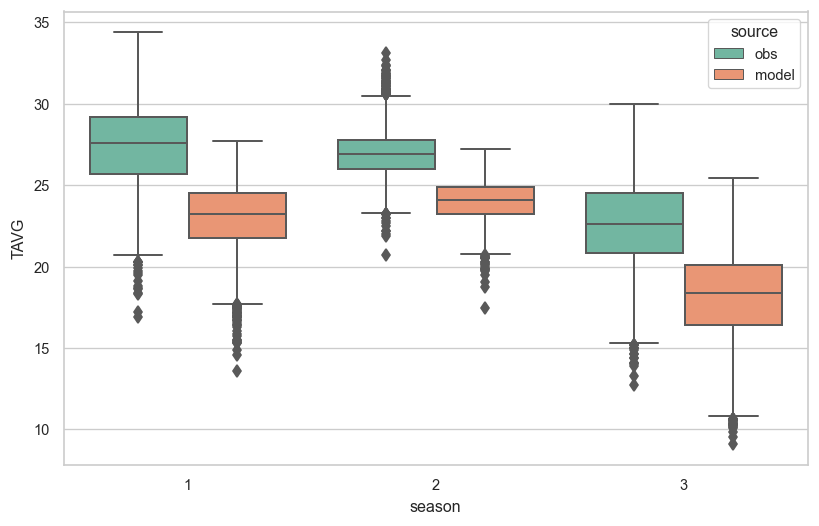

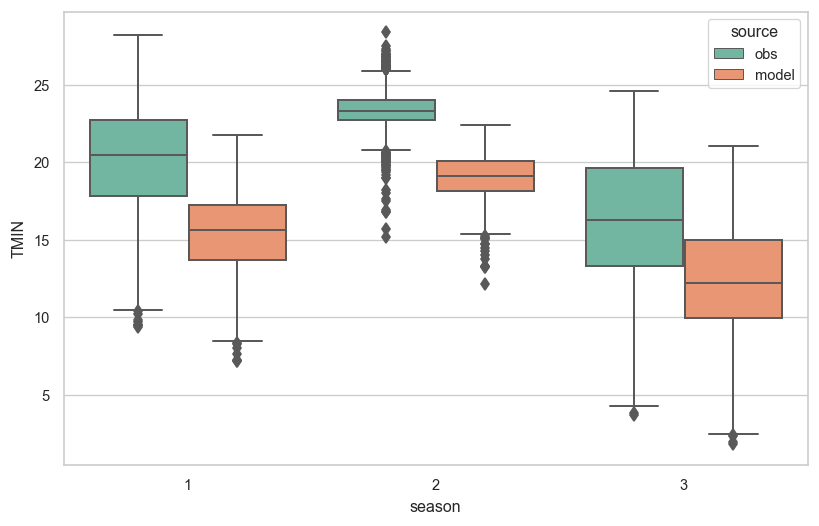

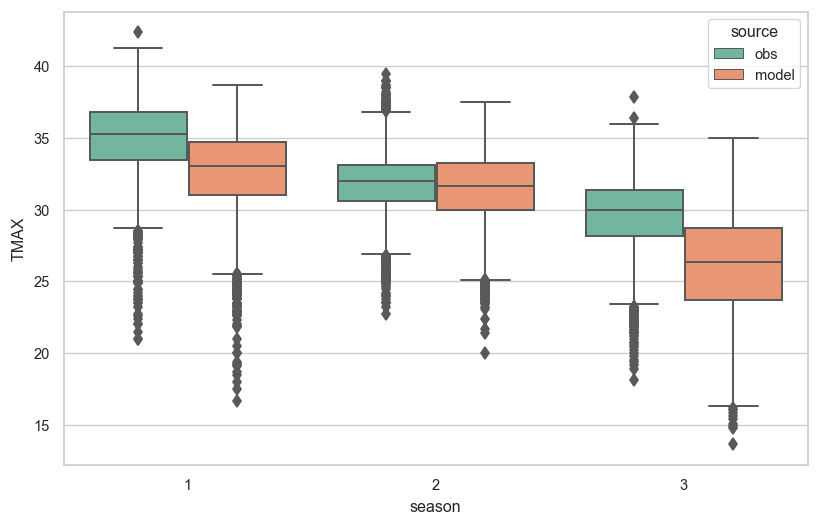

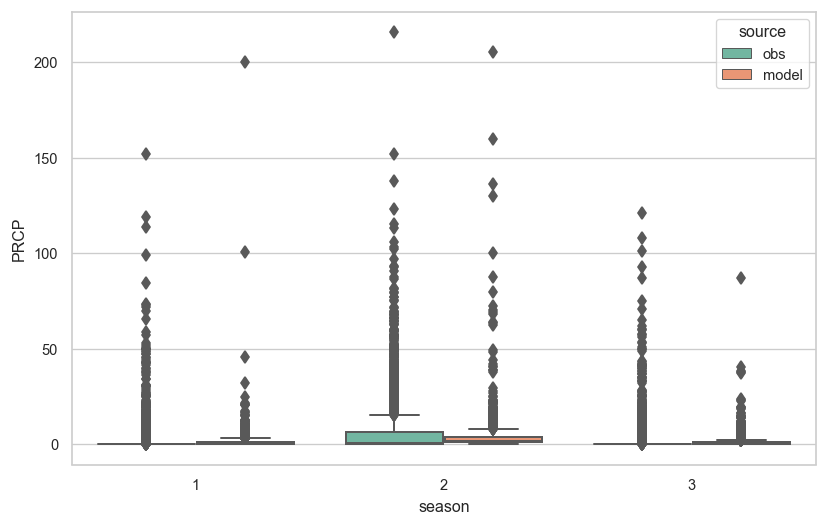

In [13]:
for variable in climate_vars:
    sns.boxplot(x='season', y=variable, data=df, hue='source')
    plt.show()

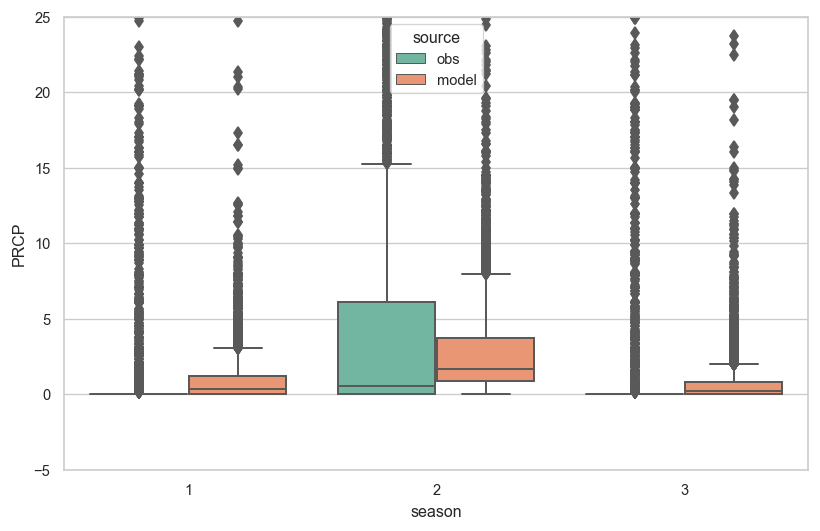

In [14]:
sns.boxplot(x='season', y='PRCP', data=df, hue='source')
plt.ylim([-5, 25])
plt.show()

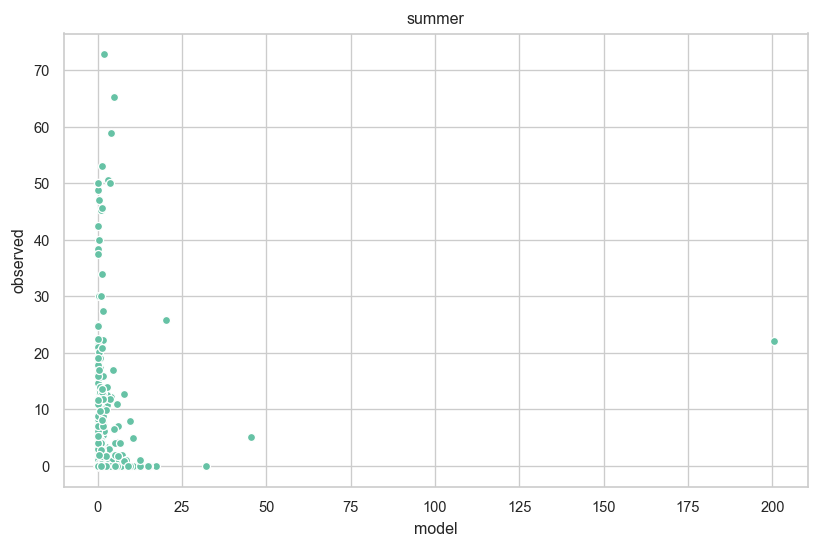

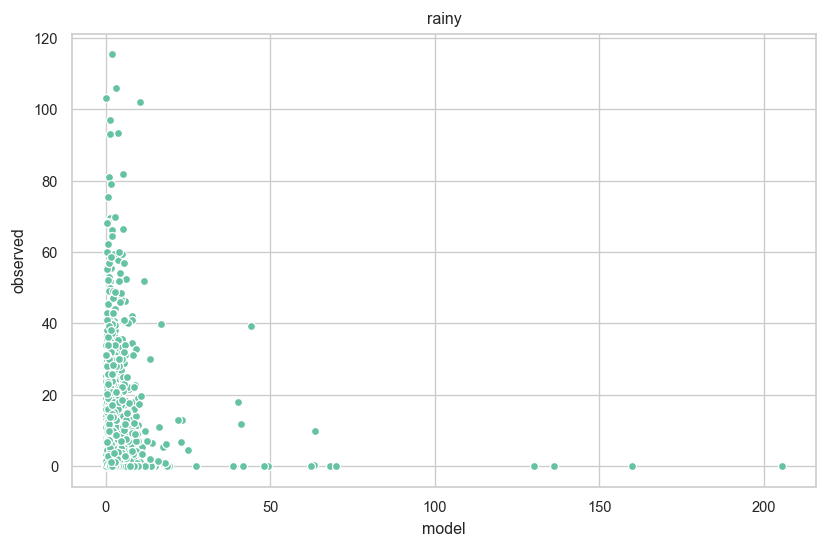

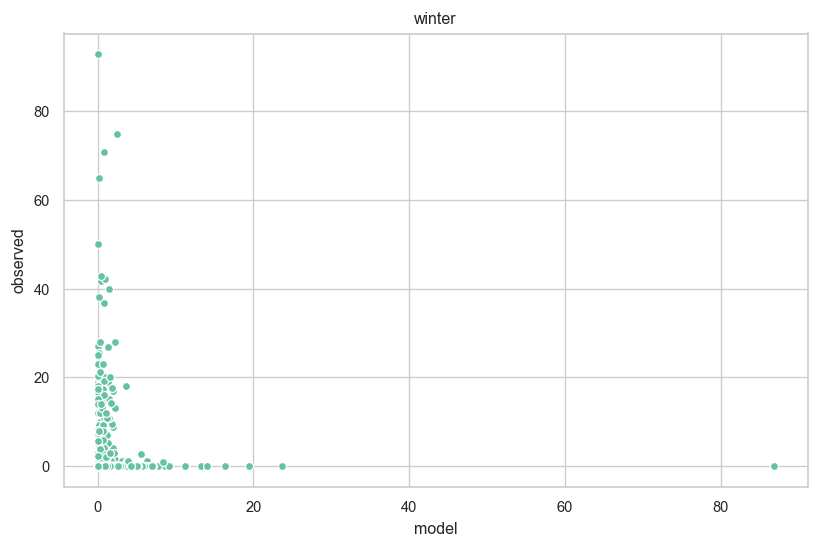

In [15]:
for season, season_code in season_encode.items():
    d = df[df['season']==season_code].dropna()
    sns.scatterplot(x=d[d['source']=='model']['PRCP'], y=d[d['source']=='obs']['PRCP'])
    plt.title(season)
    plt.xlabel('model')
    plt.ylabel('observed')
    plt.show()

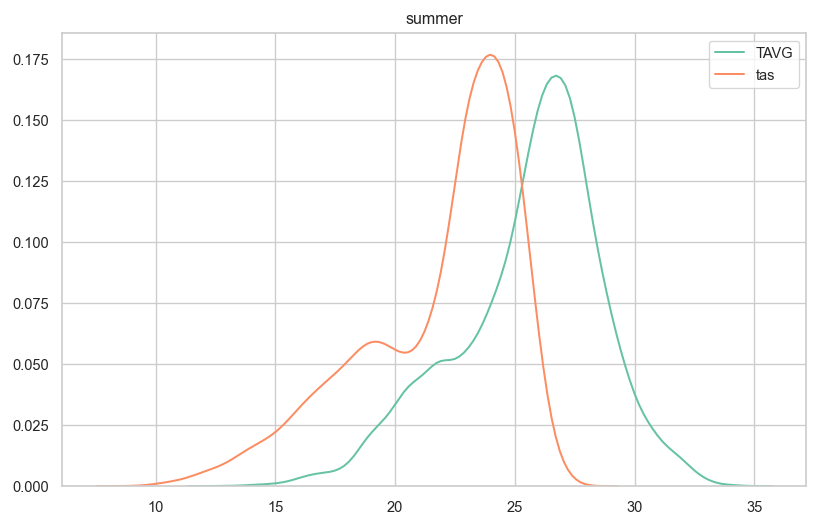

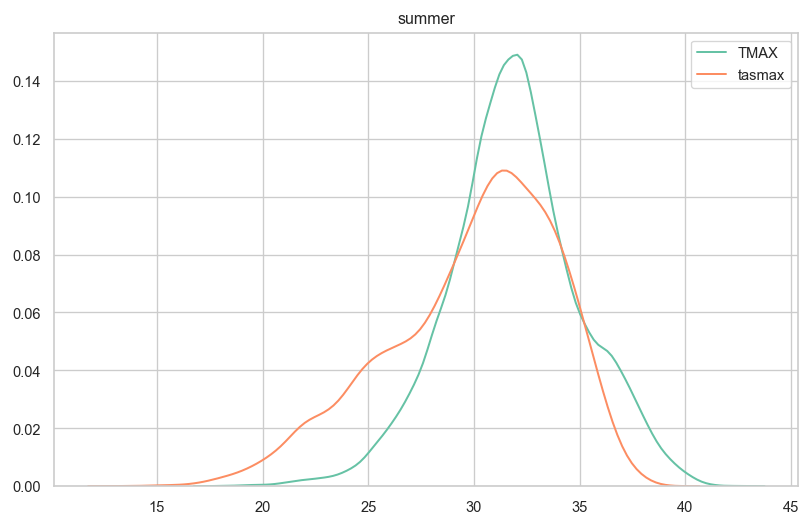

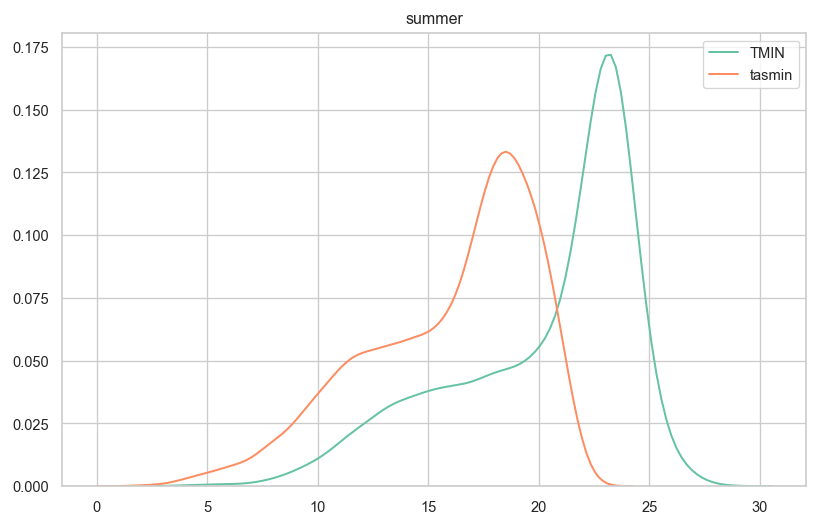

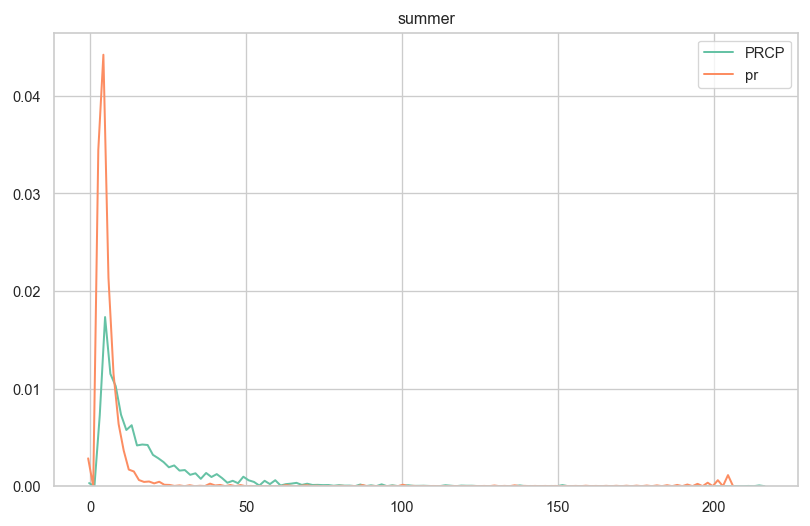

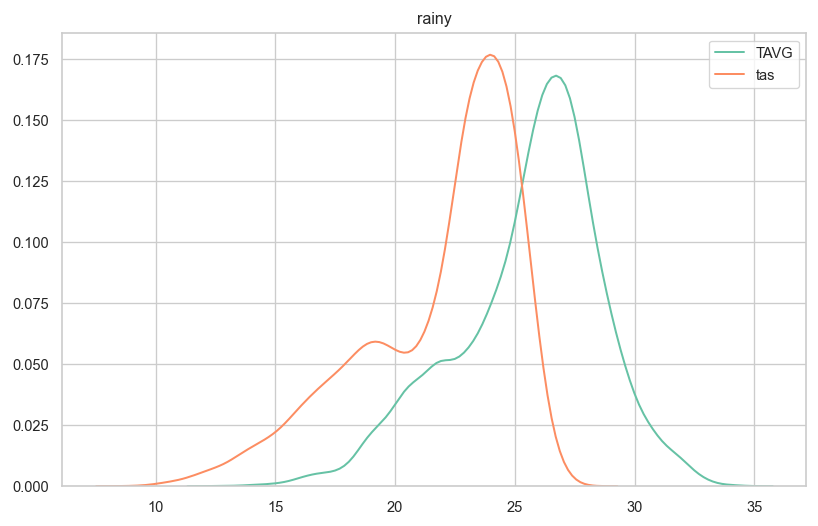

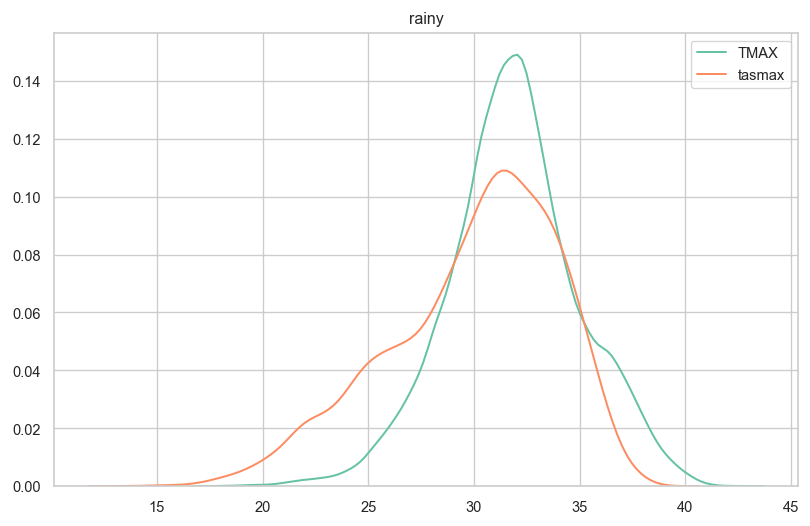

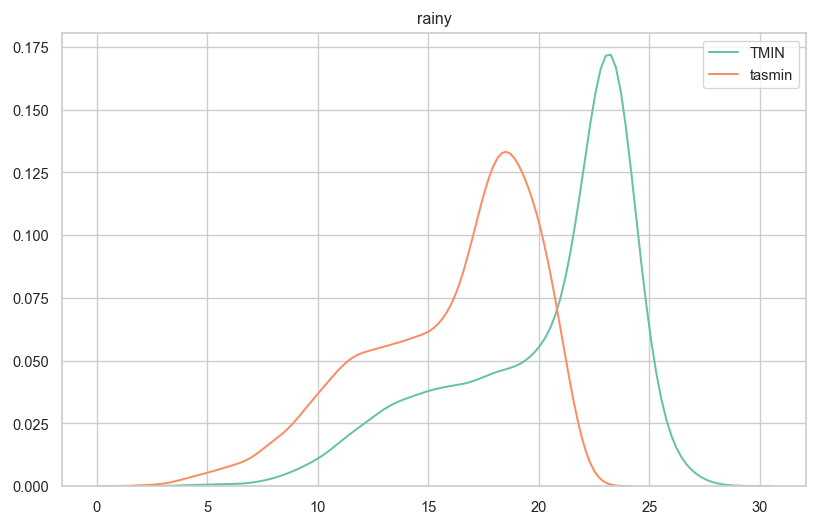

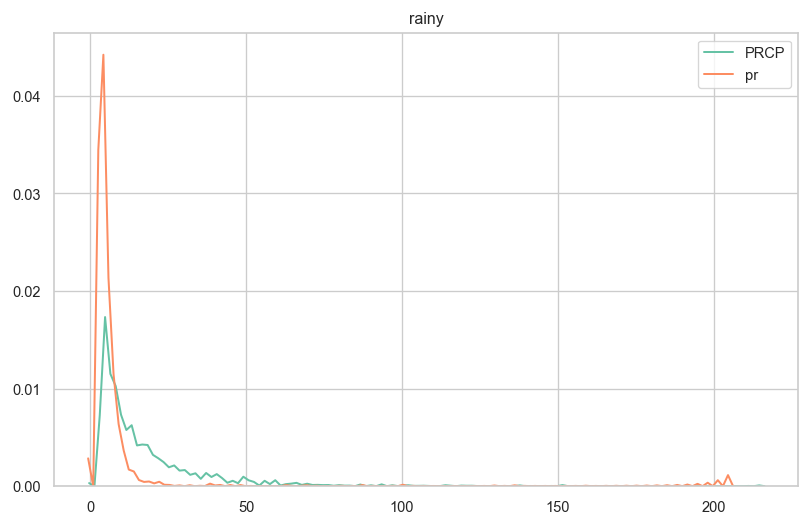

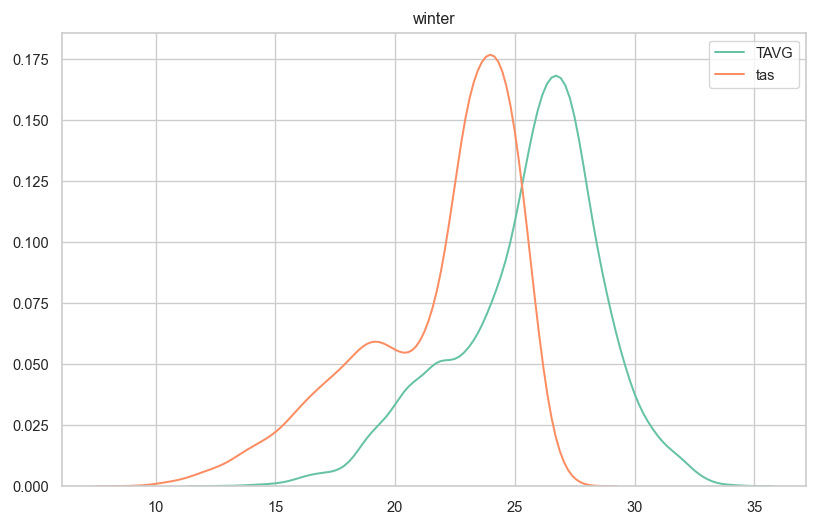

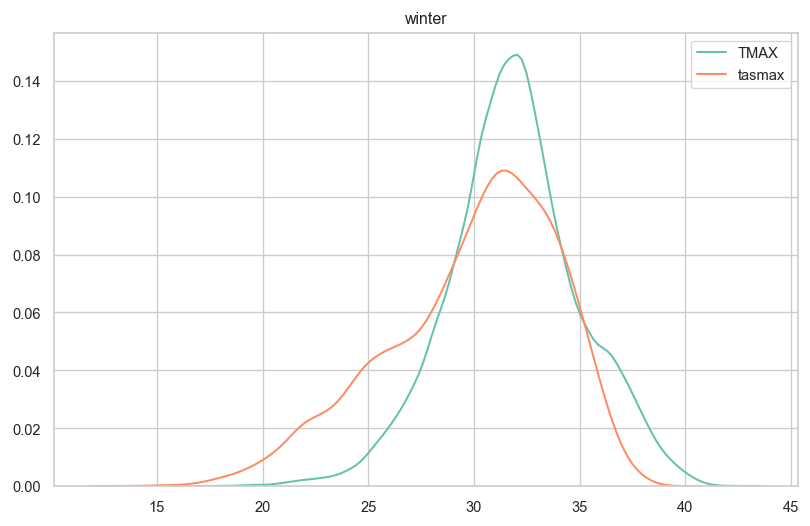

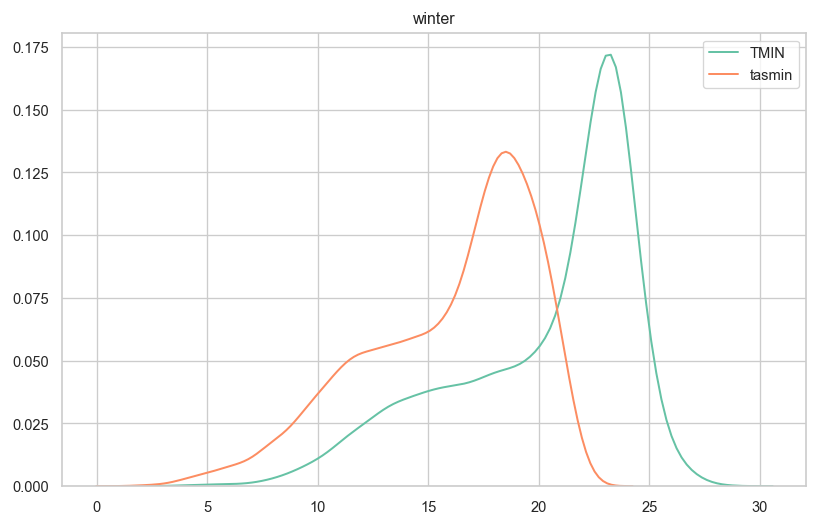

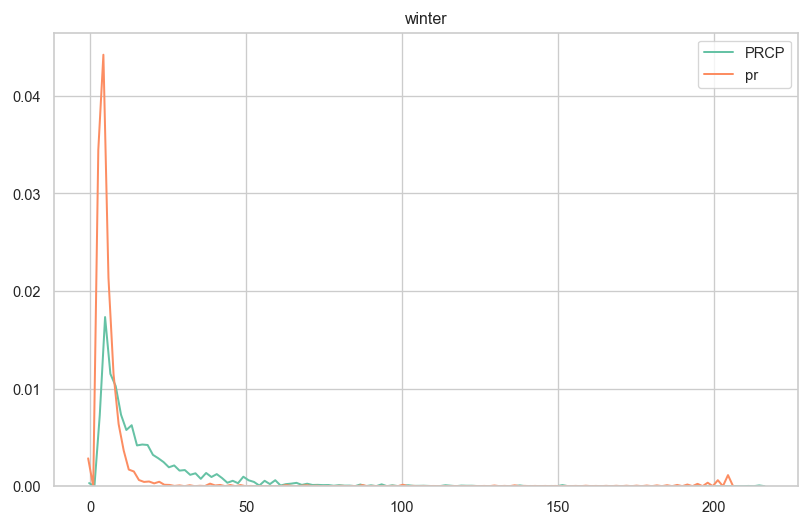

In [16]:
for season, season_code in season_encode.items():
    for obs_var, mod_var in obs_to_mod_vars.items():
        plt.title(season)
        sns.kdeplot(hist[obs_var])
        sns.kdeplot(hist[mod_var])
        plt.show()

# 
## Missing Value

In [17]:
hist.head()

,TAVG,TMIN,TMAX,PRCP,tas,tasmin,tasmax,pr,season
DATE,,,,,,,,,
1970-01-01,NaN,12.6,29.8,0.0,19.0482,11.3441,27.4118,0.306720,3
1970-01-02,NaN,13.5,29.9,0.0,20.2657,13.3224,29.5520,0.211680,3
1970-01-03,NaN,11.9,29.2,0.0,20.1890,12.9988,30.2747,0.241056,3
1970-01-04,NaN,11.8,29.4,0.0,19.2846,12.1844,27.4798,0.454464,3
1970-01-05,NaN,14.4,29.8,0.0,18.6566,11.4102,28.9179,0.120960,3


In [18]:
hist.shape

(13149, 9)

In [19]:
for variable in climate_vars:
    count_missing = len(hist[hist[variable].isna()])
    
    print(f"{variable} missing: {count_missing} rows = {count_missing/hist.shape[0]*100: 3.2f} %")

TAVG missing: 1100 rows =  8.37 %
TMIN missing: 4773 rows =  36.30 %
TMAX missing: 2145 rows =  16.31 %
PRCP missing: 991 rows =  7.54 %


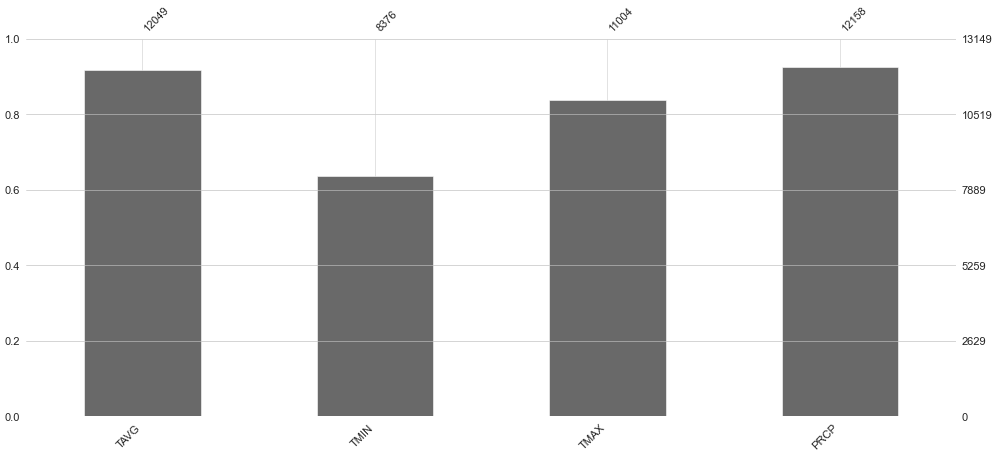

In [20]:
fig = plt.figure(figsize=(8, 5), dpi=50)
msno.bar(hist[climate_vars])
plt.show()

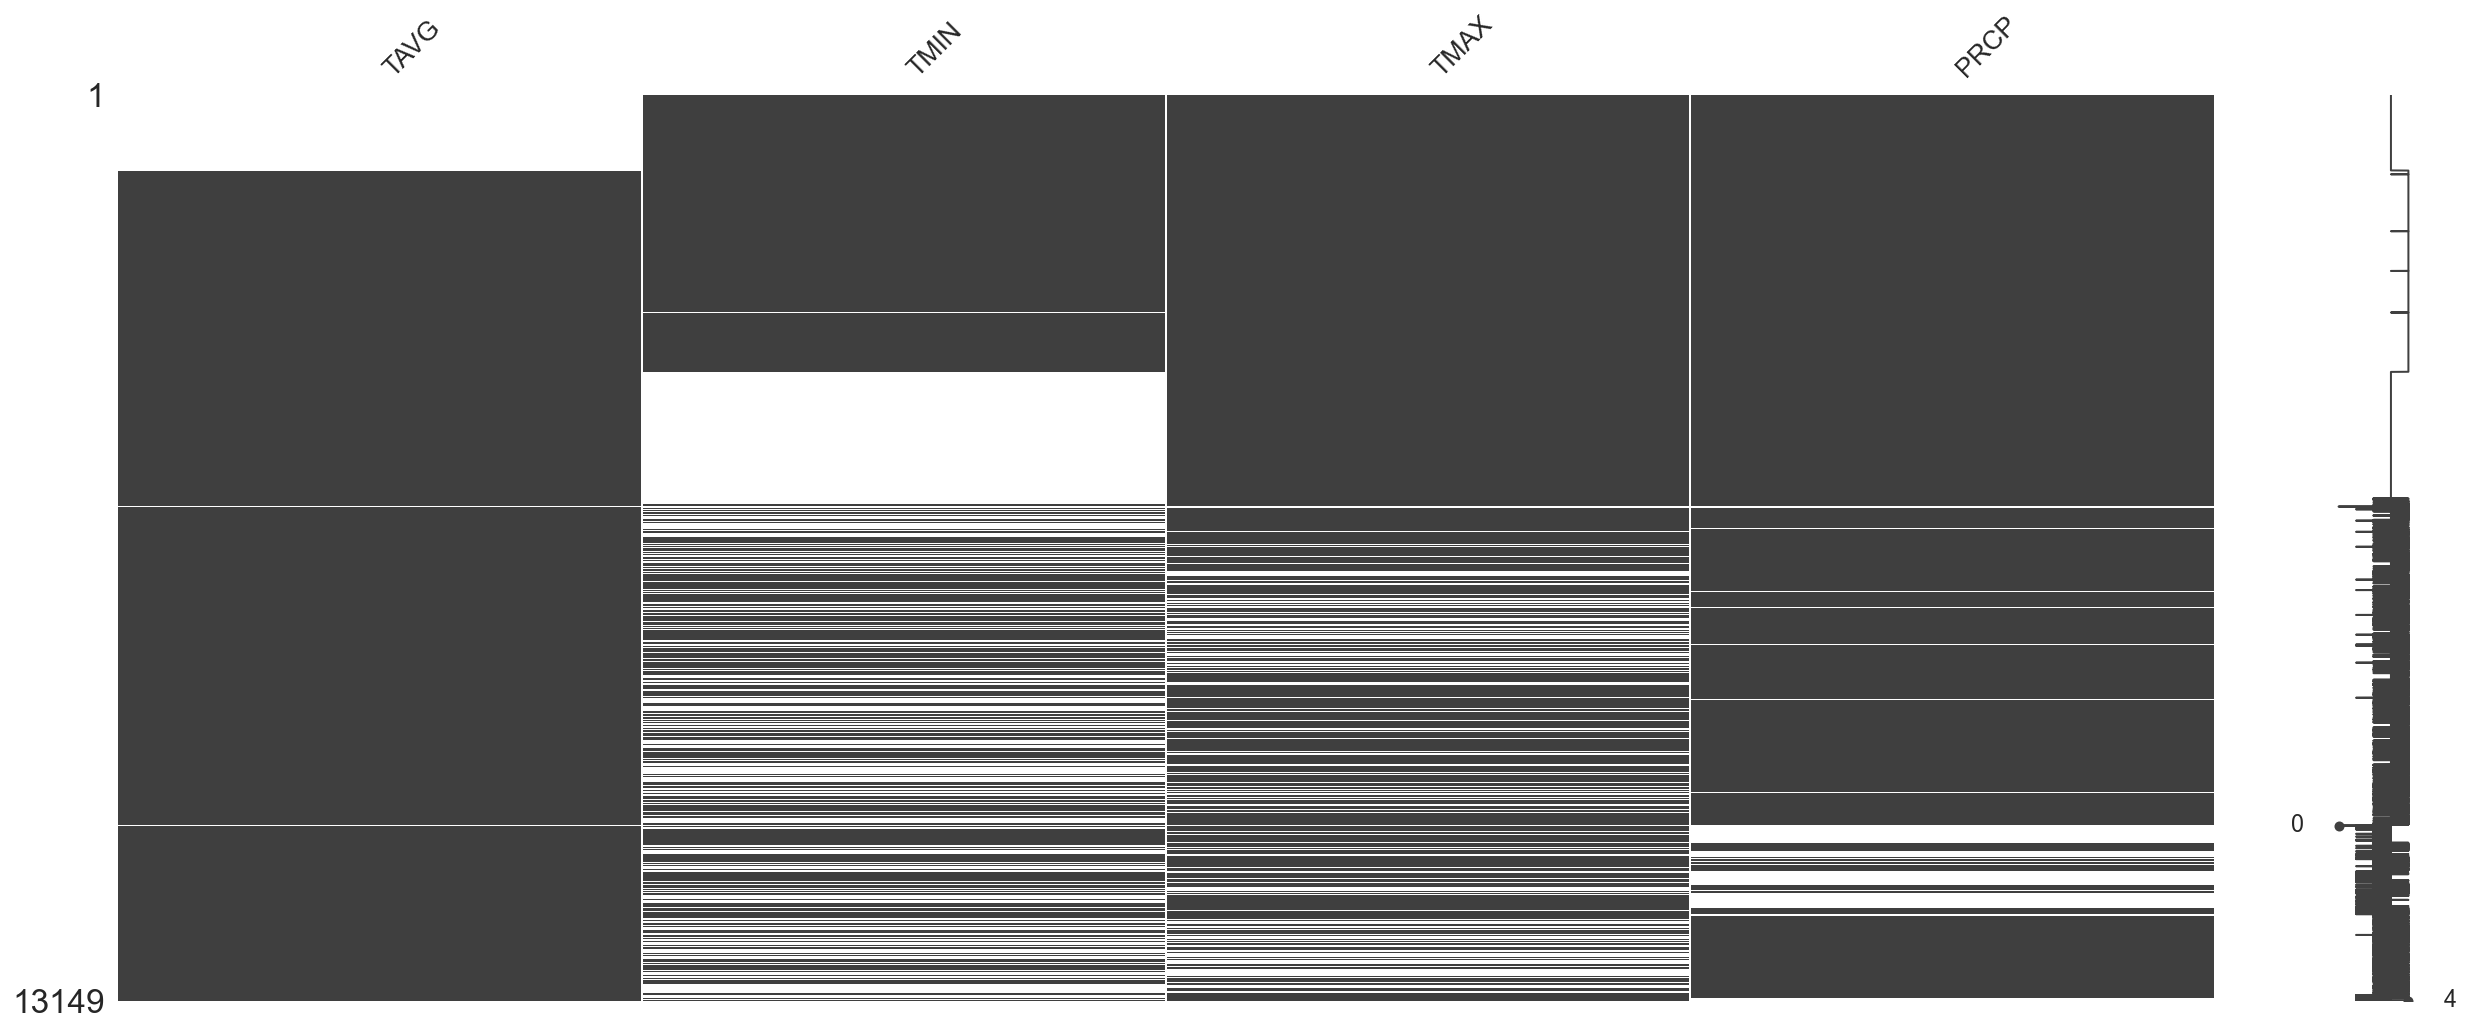

In [21]:
msno.matrix(hist[climate_vars])
plt.show()

## Missing TAVG

In [22]:
count_df = hist.isna().resample('M').sum()['TAVG']
count_df = count_df.groupby([count_df.index.year, count_df.index.month]).sum().unstack(fill_value=0)

In [23]:
count_df

DATE,1,2,3,4,5,6,7,8,9,10,11,12
DATE,,,,,,,,,,,,
1970,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
1971,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
1972,31.0,29.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
1973,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1975,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## ใช้ TAVG ปีหลังจาก 1973

In [24]:
data = hist[hist.index.year >= 1973]

In [25]:
data[data['TAVG'].isna()]

,TAVG,TMIN,TMAX,PRCP,tas,tasmin,tasmax,pr,season
DATE,,,,,,,,,
1973-02-24,NaN,14.3,35.1,0.0,18.6481,12.3428,27.9835,0.431136,1
1975-05-31,NaN,25.0,33.7,77.1,24.0021,20.2648,31.3583,2.662848,2
1986-05-09,NaN,NaN,NaN,NaN,23.7946,16.0118,33.5009,0.349056,1
1999-01-10,NaN,NaN,NaN,NaN,18.8646,11.6775,27.8070,0.000000,3


In [26]:
data.fillna(method='ffill', inplace=True)

c:\users\chuan\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [27]:
data[['TAVG', 'tas']].to_csv("./data/climate-data/tavg_clean.csv")